# Interaction-range sweep 

This notebook tests Hypothesis 2 from the project plan:  
the interaction range controls the scale of emergent structure**.

We keep attraction strength and noise fixed, and systematically sweep the interaction range.  
For each parameter setting we run multiple random seeds, discard an initial burn-in period, compute observables on the remaining trajectory, and report mean ± standard deviation across runs.

Observables (as promised in the plan):**
1. Grid-based density variance (binning)
2. Mean nearest-neighbour distance (PBC)
3. Number of clusters (connected components under distance threshold `eps`)
4. Largest cluster fraction (LCF; order parameter)

In [32]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS

In [33]:
from src.config import SimConfig, MetricsConfig

In [34]:
SIM = SimConfig(
    N=200,                
    steps=1500,
    save_every=30,
    attraction=0.10,
    noise=0.03,
    interaction_range=0.30, 
)

MET = MetricsConfig(
    eps=0.06,
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.universe_sim import run_simulation
from src.metrics import (
    nearest_neighbor_distance,
    largest_cluster_fraction,
    density_variance_grid,
    number_of_clusters,
)

print("Using project root:", PROJECT_ROOT)

Using project root: /Users/yaoxintong/Group4_Emergence-of-Structure-in-a-Simplified-Universe


## Experimental setup

We sweep `interaction_range` while keeping the remaining parameters fixed.  
For each value we run multiple seeds. We discard the first 60% of saved frames as burn-in and compute metrics on the remaining frames, then average over time and finally average over seeds.

The clustering metrics use a distance threshold `eps` (under PBC) to define connectivity.

In [36]:
# --- Simulation base settings ---
BASE = dict(
    N=200,
    steps=1500,
    box_size=1.0,
    dt=1.0,
    repulsion=0.02,
    repulsion_radius=0.05,
    save_every=30,   # saved frames ~ steps/save_every
)

# --- Fixed parameters (only sweep interaction_range) ---
FIXED = dict(
    attraction=0.02,
    noise=0.01,
)

# --- Metrics settings ---
eps = 0.06       # neighbour distance threshold for clustering
bins = 20        # grid bins for density variance
min_size = 3     # ignore tiny clusters (noise singletons)
burn_frac = 0.6  # discard first 60% saved frames

# --- Sweep settings ---
R_values = [0.10, 0.20, 0.30, 0.40, 0.60, 0.80]
seeds = list(range(10))

print("Sweep interaction_range values:", R_values)
print("Seeds:", seeds)
print("Saved frames per run ~", BASE["steps"] // BASE["save_every"])

Sweep interaction_range values: [0.1, 0.2, 0.3, 0.4, 0.6, 0.8]
Seeds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Saved frames per run ~ 50


In [37]:
def compute_metrics_from_history(history, box_size=1.0, eps=0.06, bins=20, min_size=3, burn_frac=0.6):
    """
    Compute metrics on the post burn-in part of the trajectory and average over time.
    history: np.ndarray, shape (T, N, 2)
    """
    T = history.shape[0]
    start = int(np.floor(T * burn_frac))
    frames = history[start:] if start < T else history

    nn_list, lcf_list, dv_list, nc_list = [], [], [], []

    for pos in frames:
        nn_list.append(nearest_neighbor_distance(pos, box_size))
        lcf_list.append(largest_cluster_fraction(pos, eps=eps, box_size=box_size))
        dv_list.append(density_variance_grid(pos, box_size, bins=bins, normalized=True))
        nc_list.append(number_of_clusters(pos, eps=eps, box_size=box_size, min_size=min_size))

    return {
        "nn": float(np.mean(nn_list)),
        "lcf": float(np.mean(lcf_list)),
        "densvar": float(np.mean(dv_list)),
        "nclusters": float(np.mean(nc_list)),
        "T_used": int(len(frames)),
    }

In [38]:
def run_one(seed, interaction_range):
    history = run_simulation(
        **BASE,
        **FIXED,
        interaction_range=interaction_range,
        seed=seed,
    )
    m = compute_metrics_from_history(
        history,
        box_size=BASE["box_size"],
        eps=eps,
        bins=bins,
        min_size=min_size,
        burn_frac=burn_frac,
    )
    m.update({
        "seed": seed,
        "interaction_range": float(interaction_range),
    })
    return m

In [39]:
rows = []

for r in R_values:
    for s in seeds:
        rows.append(run_one(seed=s, interaction_range=r))

raw = pd.DataFrame(rows)

# Aggregate across seeds
agg = raw.groupby("interaction_range").agg(
    nn_mean=("nn", "mean"),
    nn_std=("nn", "std"),
    lcf_mean=("lcf", "mean"),
    lcf_std=("lcf", "std"),
    densvar_mean=("densvar", "mean"),
    densvar_std=("densvar", "std"),
    nclusters_mean=("nclusters", "mean"),
    nclusters_std=("nclusters", "std"),
    runs=("seed", "count"),
).reset_index()

agg

,interaction_range,nn_mean,nn_std,lcf_mean,lcf_std,densvar_mean,densvar_std,nclusters_mean,nclusters_std,runs
0,0.1,0.032366,0.000489,0.232050,0.071114,2.3298,0.052147,15.050,1.439907,10
1,0.2,0.016343,0.001725,0.574350,0.152980,8.1782,1.430191,2.605,0.855197,10
2,0.3,0.011501,0.000981,0.958925,0.103890,14.0648,1.651821,1.120,0.315524,10
3,0.4,0.010987,0.000098,0.997500,0.000791,14.8126,0.175047,1.000,0.000000,10
4,0.6,0.010975,0.000079,0.997700,0.000563,14.8184,0.186867,1.000,0.000000,10
5,0.8,0.010996,0.000099,0.998000,0.000601,14.7453,0.221436,1.000,0.000000,10


## Results

We report mean ± standard deviation across seeds (after burn-in and time-averaging).  
We focus on LCF and number of clusters as the clearest indicators of the emergence and scale of structure.

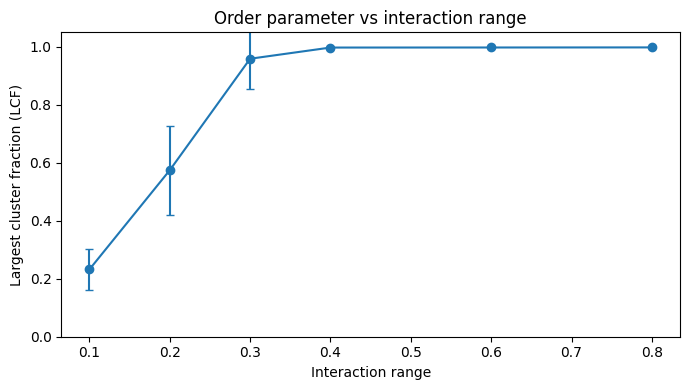

In [40]:
plt.figure(figsize=(7, 4))
plt.errorbar(agg["interaction_range"], agg["lcf_mean"], yerr=agg["lcf_std"], fmt="o-", capsize=3)
plt.ylim(0, 1.05)
plt.xlabel("Interaction range")
plt.ylabel("Largest cluster fraction (LCF)")
plt.title("Order parameter vs interaction range")
plt.tight_layout()
plt.show()

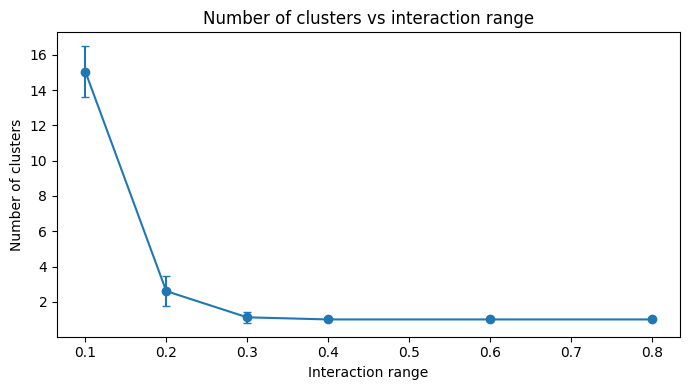

In [41]:
plt.figure(figsize=(7, 4))
plt.errorbar(agg["interaction_range"], agg["nclusters_mean"], yerr=agg["nclusters_std"], fmt="o-", capsize=3)
plt.xlabel("Interaction range")
plt.ylabel("Number of clusters")
plt.title("Number of clusters vs interaction range")
plt.tight_layout()
plt.show()

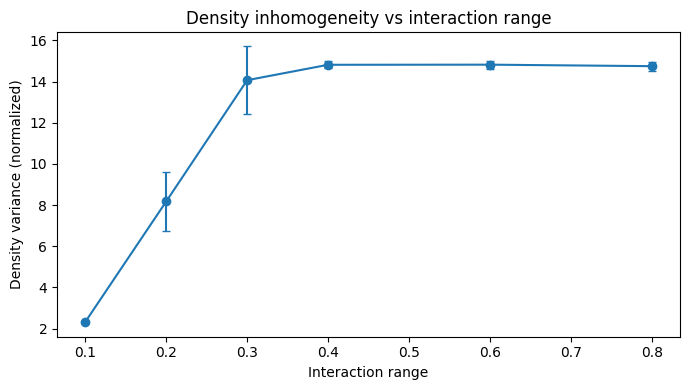

In [42]:
plt.figure(figsize=(7, 4))
plt.errorbar(agg["interaction_range"], agg["densvar_mean"], yerr=agg["densvar_std"], fmt="o-", capsize=3)
plt.xlabel("Interaction range")
plt.ylabel("Density variance (normalized)")
plt.title("Density inhomogeneity vs interaction range")
plt.tight_layout()
plt.show()

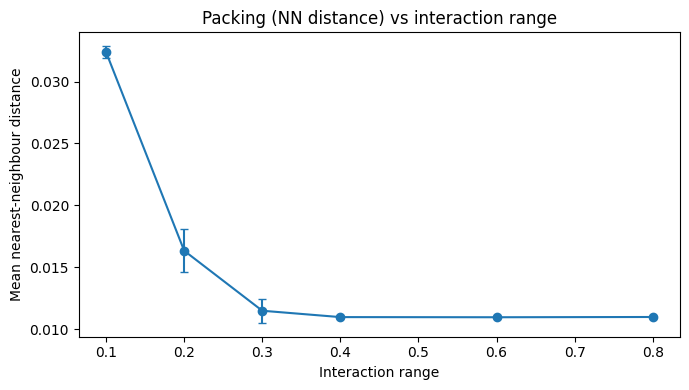

In [43]:
plt.figure(figsize=(7, 4))
plt.errorbar(agg["interaction_range"], agg["nn_mean"], yerr=agg["nn_std"], fmt="o-", capsize=3)
plt.xlabel("Interaction range")
plt.ylabel("Mean nearest-neighbour distance")
plt.title("Packing (NN distance) vs interaction range")
plt.tight_layout()
plt.show()

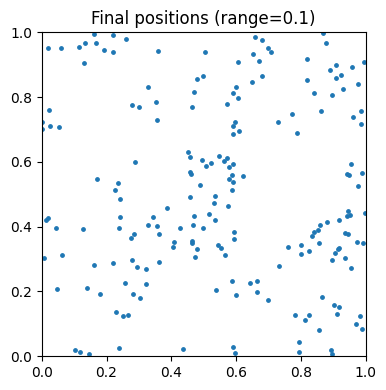

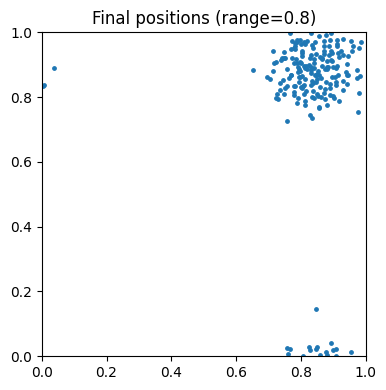

In [44]:
def final_frame(seed, interaction_range):
    h = run_simulation(**BASE, **FIXED, interaction_range=interaction_range, seed=seed)
    return h[-1]

def plot_frame(pos, title):
    plt.figure(figsize=(4, 4))
    plt.scatter(pos[:, 0], pos[:, 1], s=6)
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.tight_layout()
    plt.show()

seed_vis = 0
pos_small = final_frame(seed_vis, R_values[0])
pos_large = final_frame(seed_vis, R_values[-1])

plot_frame(pos_small, f"Final positions (range={R_values[0]})")
plot_frame(pos_large, f"Final positions (range={R_values[-1]})")

### Effect of interaction range on emergent structure

We systematically investigated the role of the interaction range by varying it while keeping all other model parameters fixed. For each parameter value, simulations were repeated with multiple random seeds, and observables were computed by time-averaging over the post–burn-in regime.

For small interaction ranges (e.g. 0.1), the system remains weakly structured, characterised by many small clusters, a low largest cluster fraction (LCF ≈ 0.23), low density variance, and large nearest-neighbour distances. As the interaction range increases, particles are able to coordinate over longer distances, leading to rapid coalescence of clusters.

A clear transition is observed around interaction_range ≈ 0.25–0.35. In this regime, the largest cluster fraction sharply increases towards unity, the number of clusters collapses to one, and density inhomogeneity rises significantly. Beyond this point (interaction_range ≥ 0.4), all observables saturate: the system robustly forms a single dominant cluster, and results become largely independent of the initial conditions, as indicated by the vanishing standard deviations across seeds.

These results support our hypothesis that increasing interaction range induces a transition from a near-homogeneous or fragmented state to a globally coordinated, clustered phase. The interaction range therefore acts as a key control parameter governing large-scale structure formation in the system.

## Critical interaction range (threshold identification)

To identify the onset of global structure formation, we define a critical interaction range based on the behavior of the order parameter, the largest cluster fraction (LCF). We consider the transition point at which the time-averaged LCF exceeds 0.5, corresponding to the emergence of a dominant connected component.

In [45]:
agg[["interaction_range", "lcf_mean", "lcf_std", "nclusters_mean", "nclusters_std"]]

,interaction_range,lcf_mean,lcf_std,nclusters_mean,nclusters_std
0,0.1,0.232050,0.071114,15.050,1.439907
1,0.2,0.574350,0.152980,2.605,0.855197
2,0.3,0.958925,0.103890,1.120,0.315524
3,0.4,0.997500,0.000791,1.000,0.000000
4,0.6,0.997700,0.000563,1.000,0.000000
5,0.8,0.998000,0.000601,1.000,0.000000


In [46]:
Rc = agg.loc[agg["lcf_mean"] > 0.5, "interaction_range"].min()
print(f"Critical interaction range Rc (LCF>0.5) ≈ {Rc:.3f}")

Critical interaction range Rc (LCF>0.5) ≈ 0.200


In [47]:
# Linear interpolation around LCF=0.5 (more quantitative)
target = 0.5
x = agg["interaction_range"].values
y = agg["lcf_mean"].values

# find first index where y crosses target
k = np.where(y >= target)[0][0]
x0, x1 = x[k-1], x[k]
y0, y1 = y[k-1], y[k]

Rc_lin = x0 + (target - y0) * (x1 - x0) / (y1 - y0)
print(f"Interpolated Rc (LCF=0.5) ≈ {Rc_lin:.3f}")

Interpolated Rc (LCF=0.5) ≈ 0.178


## Critical interaction range (threshold identification)

To quantify the onset of global structure formation, we define a critical interaction range \(R_c\) based on the order parameter, the largest cluster fraction (LCF). Specifically, we take \(R_c\) as the smallest interaction range for which the time-averaged LCF (computed over the post–burn-in regime) exceeds 0.5, indicating the emergence of a dominant connected component. For additional precision, we also report a linearly interpolated estimate of \(R_c\) between the two sampled ranges that bracket LCF = 0.5.